## Federated Leraning with logistic regression classifier

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
def parse_into_clients():

    data = np.load('mnist_data.npy')
    labels = np.load('mnist_labels.npy')
    local_datasets_data  = []
    local_datasets_label = []
    
    for i in range(20):
        local_datasets_data.append(np.copy(data[i*703:(i+1)*703]))
        local_datasets_label.append(np.copy(labels[i*703:(i+1)*703]))
    
    test_data = np.copy(data[14060:])  
    test_labels = np.copy(labels[14060:])
    
    return local_datasets_data, local_datasets_label, test_data, test_labels

client_data, client_label, test_data, test_label = parse_into_clients()

In [3]:
from sklearn.decomposition import PCA

def reduce_pca(data, n_pc):   
    
    pca = PCA(n_components=n_pc)
    pca.fit(data)
    pc = pca.components_.T
    data_r = pca.transform(data)
    
    return data_r, pc # getting the reduced data and the principle components
 
client_data_r = client_data.copy()
pcs = []

for i in range(len(client_data_r)):
    # applying the reduce_pca on client data
    client_data_r[i], pc = reduce_pca(client_data_r[i], 2)
    pcs.append(pc) # putting pcs to a list


test_data_meaned = test_data - np.mean(test_data , axis = 0) # substracting mean of data from itself
pc = np.mean(pcs, axis=0 ) # getting the average of pcs of clients
test_data_r = test_data_meaned @ pc # transforming test data using the averaged principle components

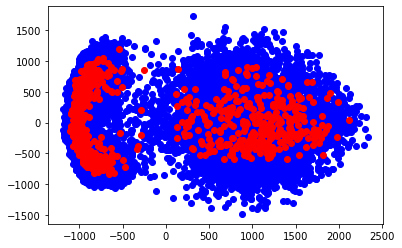

In [4]:
import matplotlib.pyplot as plt

for i in client_data_r:
    plt.scatter(i[:,0], i[:,1], color = 'b')
    
plt.scatter(test_data_r[:,0], test_data_r[:,1], color='r')
plt.show()

####  Note that the scatter plot above shows how the train and test data are scattered in two classes. test data are shown in red.

### Federating a logistic regression classifier across 20 datasets

* implementing the **FederatedAveraging** algorithm introduced in **(https://arxiv.org/pdf/1602.05629.pdf)** 
* For B = infinity (i.e., each client will be trained on all its local training samples). 


In [5]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def client_update(X, y, w, E):
    
    X = add_ones(X)
    alpha = 1e-2
    
    for e in range(E):
        
        s = sigmoid(-y * (X @ w))
        grad_w = - X.T @ (s * y)
        w = w - alpha * grad_w

    return w

def add_ones(data): # adds a column of ones to the data
    return np.concatenate((np.ones( (len(data), 1) ), data), 1)

In [6]:
# implementing the psuedo code from the paper
def fedavg_server(client_data, client_labels, num_rounds, C, E):
    
    w = np.random.randn(3, 1) # stocastic initialization
    K = len(client_data)
    M = max(np.floor(C * K), 1) # number of clients to pick
    # looping over number of communications
    for r in range(num_rounds):
        # random selection of clients
        St_index = np.random.choice(range(K), int(M)) 
        St_clients = [client_data[i] for i in range(K) if i in St_index]
        St_labels = [client_labels[i] for i in range(K) if i in St_index]

        w_clients = []
        for X, y in zip(St_clients, St_labels):
            
            y.shape = (len(y), 1) # fixing the shape of y from (703,) to (703,1)
            w_new = client_update(X, y, w, E) # calling the client to train on its data
            w_clients.append(w_new)
            
        # since n_k is the same for evey client, thus n_k/(n_k*M) = 1/M; 
        # this means we can use the average of the w_clients list.
        w = np.mean(np.array(w_clients), axis=0)
        
    return w

In [7]:
def calc_acuracy(w, X_test, y_test):

    y_hat = sigmoid(X_test @ w) # getting the prediction score
    y_hat[y_hat > .5] = 1 # getting the correlated class
    y_hat[y_hat <=.5] = 0 # getting the correlated class
    accuracy = np.sum(y_test == y_hat) / len(y_test) # calculating accuracy
    
    return accuracy

In [8]:
test_data_r = add_ones(test_data_r) # adding the ones column
test_label.shape = (len(test_label), 1) # fixing the shape of test_label from (720,) to (720,1)

In [9]:
accuracies = []
# running the server with different number of epochs
for E in [1, 5, 10]:
    
    w_star = fedavg_server(client_data_r, client_label, num_rounds=1, C=.1, E=E)

    accuracy = calc_acuracy(w_star, test_data_r, test_label)
    accuracies.append(accuracy)
    print('Accuracy of the model with E=%s is %.4f'%(E, accuracy))

Accuracy of the model with E=1 is 0.9653
Accuracy of the model with E=5 is 0.9972
Accuracy of the model with E=10 is 0.9972


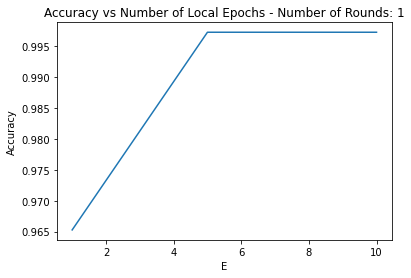

In [10]:
# plotting the accuracies
plt.plot([1, 5, 10], accuracies)
plt.xlabel('E')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Local Epochs - Number of Rounds: 1')
plt.show()

### Discussion
Sicne the convergence is really fast, with 2 rounds of communications, we can see that with a single local epoch the overall accuracy is low on the test set. However, with higher number of epochs for each client, it seems that the w approaches to global minia and thus, the accuracy of the model improves.
<br><br>

